# Dissecting racial bias in a medical risk score

---

ML Failures lab: Dissecting Racial Bias in a Medical Risk Score by Nick Merrill, Inderpal Kaur, Samuel Greenberg is licensed under [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0).

**Students** can [provide feedback here](https://docs.google.com/forms/d/1jI8oXRkqD1l1ARuZR1y9W_qkOystPr-YEyywNDez46M/edit?ts=5efa772a&dods).

# Background

To effectively manage patients, health systems often need to estimate particular
patients' health risks. Using quantitative measures, or "risk scores,"
healthcare providers can prioritize patients and allocate resources to patients
who need them most.

In this lab, we examine an algorithm widely-used in industry to establish quantitative risk scores for patients. This algorithm uses *medical cost* (i.e., the amount a patient spends on medical care) as a proxy for risk. Through analysis of this data, we will discover how this algorithm embeds a bias against Black patients, undervaluing their medical risk relative to White patients. Crucially, this bias is not immediately visible when comparing medical costs across White and Black pateints.

The key insight of [Obermeyer et al's work](https://science.sciencemag.org/content/366/6464/447) is that bias frequently slips into algorithmic systems unnoticed, particularly when sensitive characteristics (such as race) are ommitted or backgrounded in the data science process. In this case, bias in algorithms affects people's lives very concretely: the bias in the algorithm described here would make it more difficult for Black patients to recieve the care they need.

In this lab, we will learn how to uncover bias in algorithms, using the medical risk score example from Obermeyer et al's paper.

## Agenda

- Investigate relationship between medical cost and risk by race
- Investigate relationship between chronic illness and risk by race
- Investigate interactions between medical cost and chronic illness
- Discussion

In [2]:
# %%capture
# !pip install pandas
# !pip install seaborn
# !pip install statsmodels

In [3]:
%%capture

# import statements
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

# load the data we will need
# download this data at
# https://github.com/daylight-lab/mlfailures/blob/master/health-care-bias-lab.csv
# !wget https://raw.githubusercontent.com/daylight-lab/mlfailures/master/health-care-bias-lab.csv
data = pd.read_csv('health-care-bias-lab.csv')

In [4]:
# let's run some initial data exploration
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48784 entries, 0 to 48783
Columns: 160 entries, risk_score_t to gagne_sum_t
dtypes: float64(22), int64(137), object(1)
memory usage: 59.6+ MB


,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,dem_female,...,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t
count,48784.000000,48784.000000,48784.000000,48784.000000,38116.000000,13252.000000,21268.000000,23971.000000,19456.000000,48784.000000,...,48784.000000,48784.000000,48784.000000,48784.000000,48784.000000,48784.000000,48784.000000,48784.000000,48784.000000,48784.000000
mean,4.393692,0.009265,7659.716300,2434.722450,127.333272,5.959331,40.428418,0.957342,103.820203,0.630596,...,0.090091,0.261807,0.028882,0.097245,0.256088,0.027939,0.107228,0.251455,1.443137,1.354481
std,5.519582,0.095811,17989.921192,12058.341779,16.337397,1.000817,4.231178,0.565138,32.944924,0.482648,...,0.286315,0.439623,0.167478,0.296294,0.436476,0.164801,0.309406,0.433854,2.048888,1.942488
min,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,20.811111,0.236667,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.443859,0.000000,1200.000000,0.000000,118.000000,5.400000,38.100000,0.750000,80.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.887719,0.000000,2800.000000,0.000000,127.000000,5.700000,40.700000,0.875000,101.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,5.350773,0.000000,6600.000000,100.000000,136.000000,6.100000,43.121970,1.035000,124.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,2.000000,2.000000
max,100.000000,1.000000,550500.000000,642700.000000,1323.000000,14.733333,70.280000,22.206667,387.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.000000,17.000000


In [5]:
#utility function
def convert_to_percentile(df, col_name):
    """Convert column to percentile.

    Parameters
    ----------
    df : pd.DataFrame
        Data dataframe.
    col_name : str
        Name of column in df to convert to percentile.

    Returns
    -------
    pd.Series
        Column converted to percentile from 1 to 100

    """
    return pd.qcut(df[col_name].rank(method='first'), 100,
                   labels=range(1, 101))

## Medical cost and risk

To help hospitals and insurance companies identify patients who should qualify for “high-risk care management” programs, the algorithm assigns each patient a risk score. It predicts a patient’s total medical expenditure based on data from insurance claims (age, sex, diagnosis codes, etc.) and uses this variable as a proxy for health care needs.  Patient risk scores are then generated as functions of their predicted expenditures.

If the model is calibrated across race in terms of risk score and expenditure, Black and White patients with a given risk score should have similar total medical expenditures, on average.

To see if this is true, we will generate a graph that shows the mean total medical expenditure by race given a risk score percentile.

First, let's load our medical data. This data represents the estimated risk across patients, along with other details about each patient. You can [grab the data here](https://github.com/daylight-lab/mlfailures/blob/master/health-care-bias-lab.csv). (If you're using this lab as a Jupyter notebook on your computer, place the file in the same directory as your lab. If you're using Google Colab, Click the Files menu in the sidebar and press the upload file button to upload this CSV.)

In [6]:
# add a column of risk percentiles to the dataframe called 'risk_percentile'
risk_percentile = convert_to_percentile(data, "risk_score_t")
data["risk_percentile"] = risk_percentile
data.head()

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t,risk_percentile
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,...,0,0,0,0,0,0,0,0,0,36
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,...,1,0,0,1,0,0,1,4,3,86
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,4
3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,11
4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,white,...,0,0,0,0,0,0,0,1,1,98


In [7]:
# TODO create dataframe called `group_cost` with the mean total medical expenditure (`cost_t`) for each race (`race`) at each risk percentile (`risk_percentile`)
group_cost = data.groupby(["race", "risk_percentile"])[["cost_t"]].mean().reset_index()
group_cost

/var/folders/0l/p7x7d7755vq4wc8qty73kcy40000gn/T/ipykernel_81386/4160514407.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_cost = data.groupby(["race", "risk_percentile"])[["cost_t"]].mean().reset_index()


,race,risk_percentile,cost_t
0,black,1,1033.333333
1,black,2,1365.079365
2,black,3,1271.428571
3,black,4,2127.868852
4,black,5,1400.000000
...,...,...,...
195,white,96,23345.609756
196,white,97,21824.228029
197,white,98,31951.312649
198,white,99,30900.000000


In [8]:
# TODO Divide `group_cost` into two dataframes based on race
#      Call the two dataframes `b_cost` and `w_cost`.
b_cost = group_cost[group_cost['race'] == 'Black']
w_cost = group_cost[group_cost['race'] == 'White']

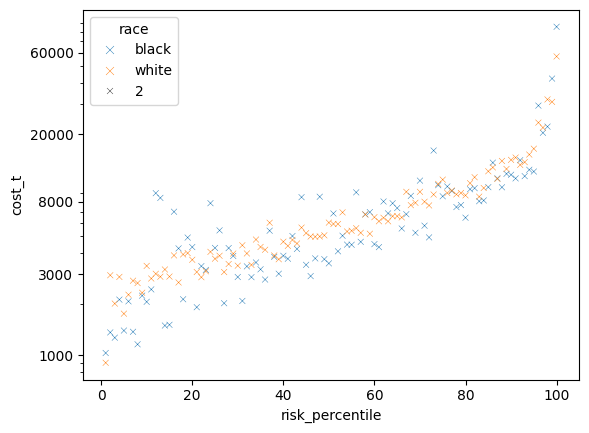

In [9]:
# Plot risk percentile against cost, splitting on race
ax = sns.scatterplot(x = "risk_percentile", y = "cost_t", data = group_cost, hue = "race", marker = "x", size = 2, legend = "full")
plt.yscale('log')
ax.set_yticks([1000, 3000, 8000, 20000, 60000])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend;


**QUESTION: What do you notice about the relationship between medical expenditure and risk score by race? Can you conclude from this data that the model is fair or not fair?**

**OPTIONAL**: Fit a LOWESS (locally weighted scatterplot smoothing) model to the scatterplot. Or perhaps there's some other model you'd like to try out.

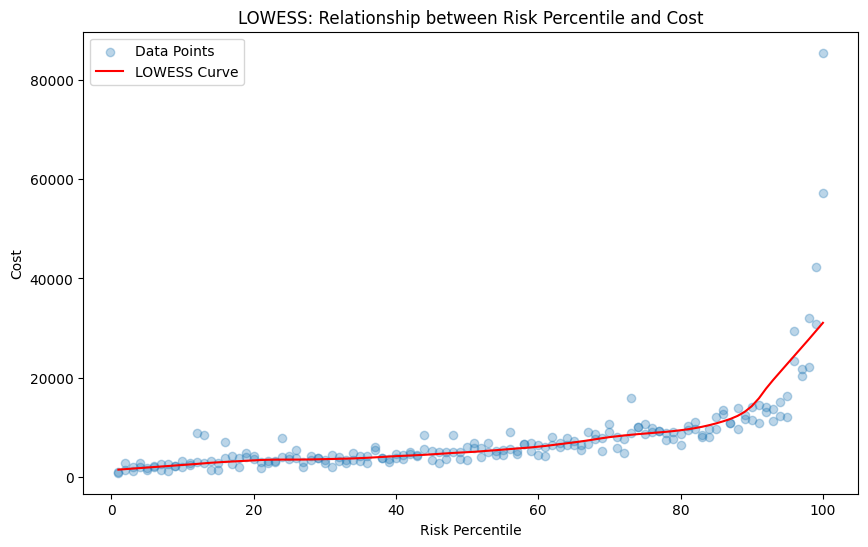

In [10]:
# fit a LOWESS model and conduct some analysis for the result

lowess_results = lowess(group_cost["cost_t"], group_cost["risk_percentile"], frac=0.2)
lowess_x, lowess_y = zip(*lowess_results)

plt.figure(figsize=(10, 6))
plt.scatter(group_cost["risk_percentile"], group_cost["cost_t"], alpha=0.3, label="Data Points")
plt.plot(lowess_x, lowess_y, color='red', label="LOWESS Curve")
plt.xlabel("Risk Percentile")
plt.ylabel("Cost")
plt.title("LOWESS: Relationship between Risk Percentile and Cost")
plt.legend()
plt.show()


## Chronic illness and risk

Next, we will check to see if the model is calibrated across groups in terms of risk score and chronic illness. In other words: for a given risk score, do Black and white patients have the same "level" of health?

If cost is a good proxy for need, we would expect this graph to be as balanced as the prior graph.  In other words, health care cost should not vary conditional on health between groups.

In [11]:
# TODO Group the data by `risk_percentile` and `race`.
grouped_by_race = data.groupby(['race', 'risk_percentile'])['gagne_sum_t'].mean().reset_index()

# TODO Take the mean number of chronic illnesses (`gagne_sum_t`) in each group of race + risk percentile.
#      Call that dataframe `grouped_by_race`
grouped_by_race

/var/folders/0l/p7x7d7755vq4wc8qty73kcy40000gn/T/ipykernel_81386/3417210326.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_race = data.groupby(['race', 'risk_percentile'])['gagne_sum_t'].mean().reset_index()


,race,risk_percentile,gagne_sum_t
0,black,1,0.079365
1,black,2,0.206349
2,black,3,0.317460
3,black,4,0.213115
4,black,5,0.279412
...,...,...,...
195,white,96,3.826829
196,white,97,4.109264
197,white,98,4.863962
198,white,99,4.869458


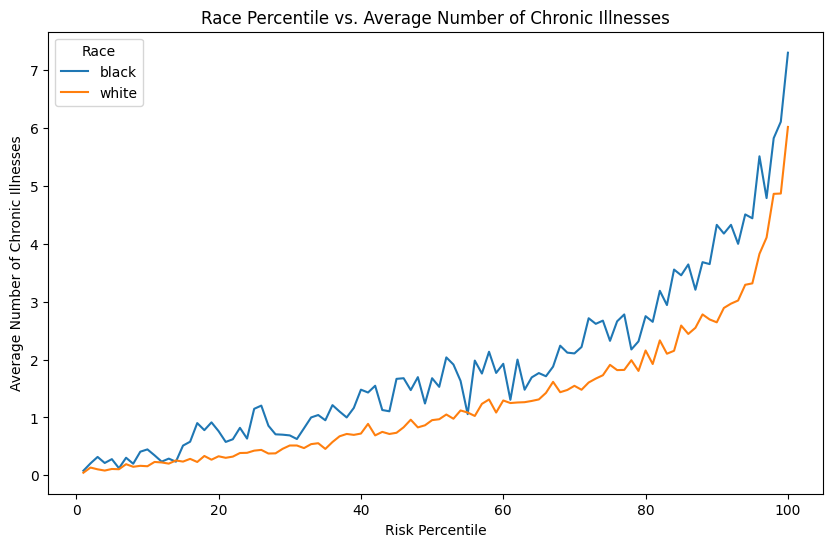

In [12]:
# TODO Plot risk percentile against average number of chronic illnesses, splitting on race
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_by_race, x='risk_percentile', y='gagne_sum_t', hue='race')
plt.title("Race Percentile vs. Average Number of Chronic Illnesses")
plt.xlabel("Risk Percentile")
plt.ylabel("Average Number of Chronic Illnesses")
plt.legend(title='Race')
plt.show()

**QUESTION: What do you notice about the relationship between chronic illness and risk score by race?  Can you conclude from this data that the model is fair or not fair?**

**OPTIONAL**: Fit two generalized linear models, one  the white patients and one to the Black patients. Plot the two models. (Perhaps there's some other type of model you'd like to try as well).

                 Generalized Linear Model Regression Results                  
Dep. Variable:            gagne_sum_t   No. Observations:                43202
Model:                            GLM   Df Residuals:                    43200
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          2.3748
Method:                          IRLS   Log-Likelihood:                -79983.
Date:                Wed, 19 Mar 2025   Deviance:                   1.0259e+05
Time:                        10:09:33   Pearson chi2:                 1.03e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3534
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.5173      0.015    -

/var/folders/0l/p7x7d7755vq4wc8qty73kcy40000gn/T/ipykernel_81386/512726846.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_data["predicted_gagne_sum_t"] = glm_results.predict(x)


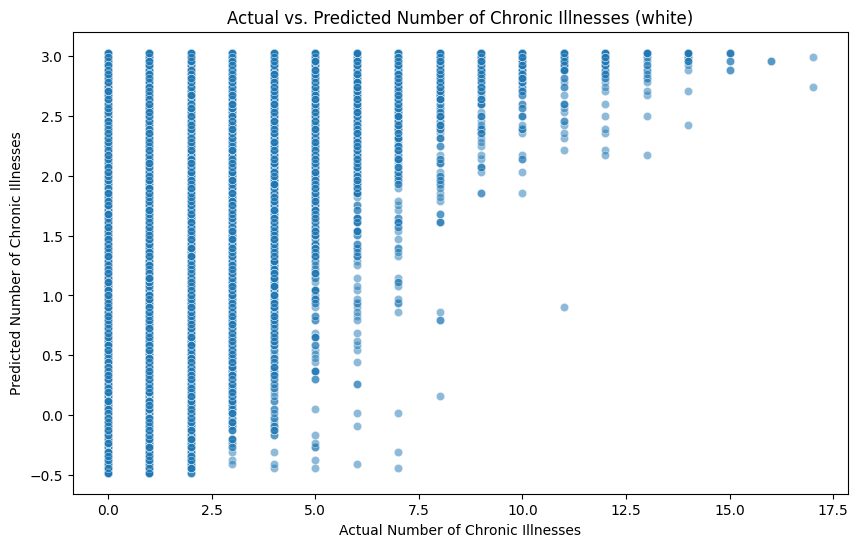

                 Generalized Linear Model Regression Results                  
Dep. Variable:            gagne_sum_t   No. Observations:                 5582
Model:                            GLM   Df Residuals:                     5580
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          3.7891
Method:                          IRLS   Log-Likelihood:                -11637.
Date:                Wed, 19 Mar 2025   Deviance:                       21143.
Time:                        10:09:33   Pearson chi2:                 2.11e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4464
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.5619      0.052    -

/var/folders/0l/p7x7d7755vq4wc8qty73kcy40000gn/T/ipykernel_81386/512726846.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_data["predicted_gagne_sum_t"] = glm_results.predict(x)


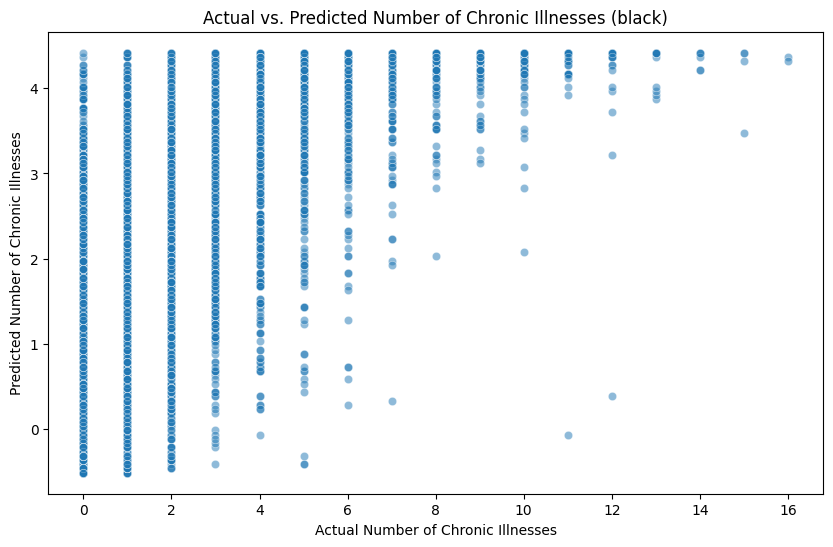

In [13]:
# fit two generalized linear models and plot the two models
import statsmodels.api as sm
# Generalized Linear Model (GLM) Analysis

for race in ["white", "black"]:
    # Filter the data
    race_data = data[data["race"] == race]
    x = sm.add_constant(race_data["risk_percentile"])
    y = race_data["gagne_sum_t"]
    
    # fit model
    glm_model = sm.GLM(y, x, family=sm.families.Gaussian())
    glm_results = glm_model.fit()
    
    print(glm_results.summary())
    
    # plot the model
    plt.figure(figsize=(10, 6))
    race_data["predicted_gagne_sum_t"] = glm_results.predict(x)
    sns.scatterplot(x=race_data["gagne_sum_t"], y=race_data["predicted_gagne_sum_t"], alpha=0.5)
    plt.xlabel("Actual Number of Chronic Illnesses")
    plt.ylabel("Predicted Number of Chronic Illnesses")
    plt.title(f"Actual vs. Predicted Number of Chronic Illnesses ({race})")
    plt.show()
    
    

## Interactions between cost and illness

Our work above shows us that a Black patient and a White patient with the same risk score tend to spend the same amount on medical care on average, yet the Black patient tends to have more chronic illnesses.

To understand this interaction, generate a graph that shows the mean total medical expenditure by race, given the number of chronic illnesses.

In [14]:
# add a column of illness percentiles to the dataframe called 'illness_percentile'
illness_percentile = convert_to_percentile(data, "gagne_sum_t")
data['illness_percentile'] = illness_percentile
data.head()

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t,risk_percentile,illness_percentile
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,...,0,0,0,0,0,0,0,0,36,1
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,...,0,0,1,0,0,1,4,3,86,82
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,4,1
3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,11,1
4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,white,...,0,0,0,0,0,0,1,1,98,46


In [23]:
# TODO Group the data by `illness_percentile` and `race`.
#      Take the mean total medical expenditure (`cost_t`) for each group of race + illness percentile.
#      Call the dataframe called `illnesses_cost`

illnesses_cost = data.groupby(['illness_percentile', 'race'])['cost_t'].mean().reset_index()

# TODO gropu data by 'race' and 'risk_percentile' and take mean of 'illness_percentile' for each group of race +  race_percentile
#      Call the dataframe called `illnesses`

data["risk_percentile"] = data["risk_percentile"].astype(int)
data["illness_percentile"] = data["illness_percentile"].astype(int)
illnesses = data.groupby(["race", "risk_percentile"])["illness_percentile"].mean().reset_index()


# TODO divide illnesses into two dataframes based on race: `illness_b` and `illness_w`
illness_b = illnesses[illnesses["race"] == "black"]
illness_w = illnesses[illnesses["race"] == "white"]


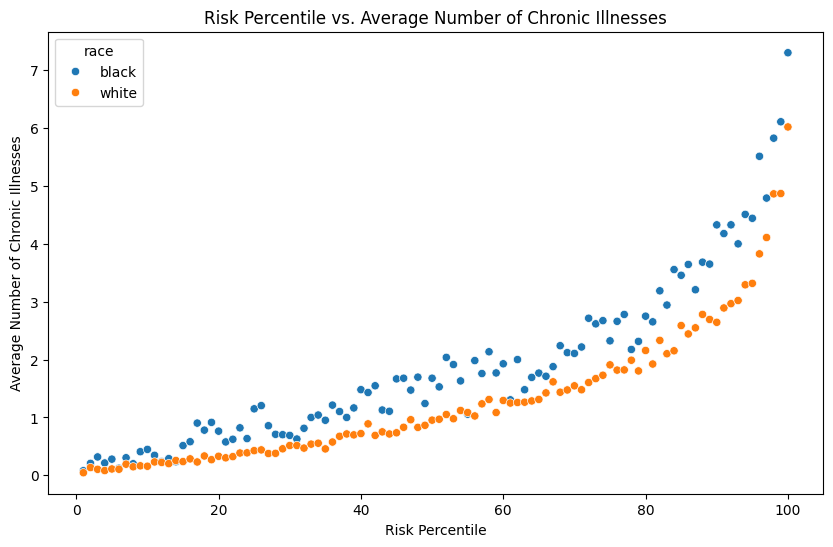

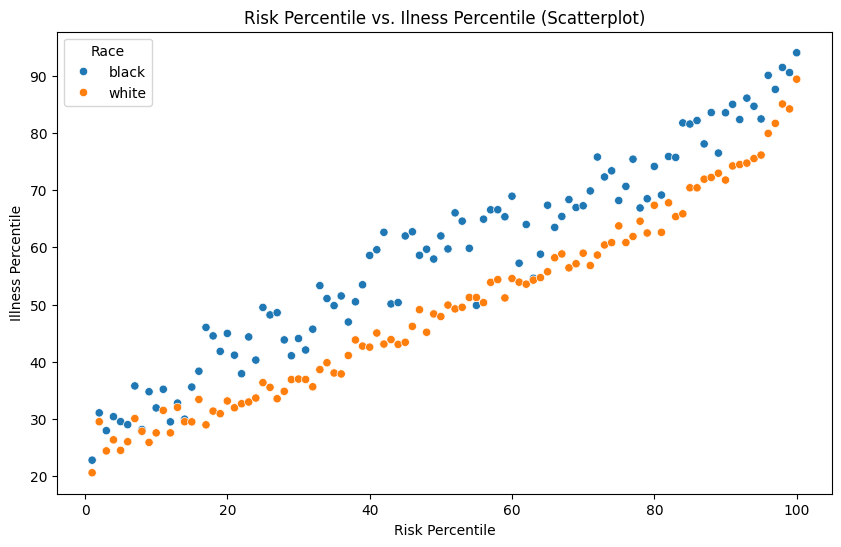

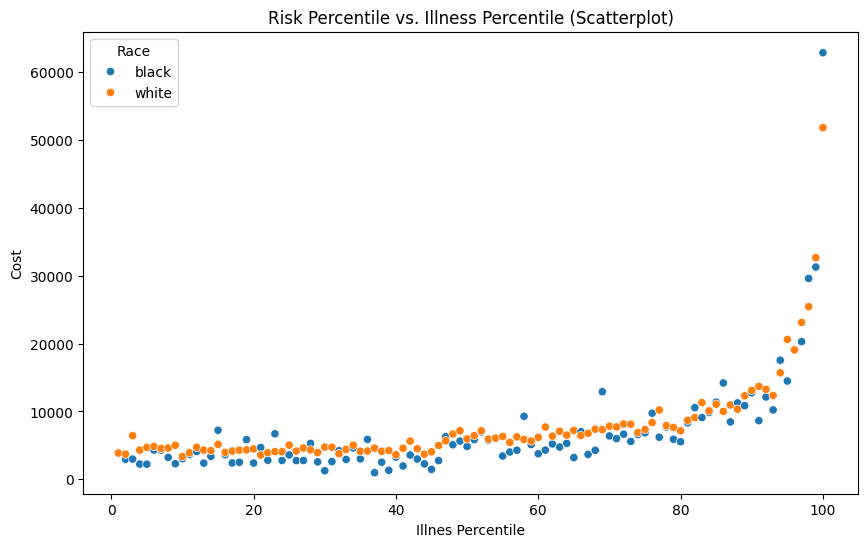

In [24]:
# TODO create a scatterplot of risk percentile against average number of chronic ilnesses, splitting on race
plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped_by_race, x="risk_percentile", y="gagne_sum_t", hue="race")
plt.title("Risk Percentile vs. Average Number of Chronic Illnesses")
plt.xlabel("Risk Percentile")
plt.ylabel("Average Number of Chronic Illnesses")
plt.show()
plt.figure(figsize=(10, 6))
sns.scatterplot(data=illnesses, x="risk_percentile", y="illness_percentile", hue="race")
plt.title("Risk Percentile vs. Ilness Percentile (Scatterplot)")
plt.xlabel("Risk Percentile")
plt.ylabel("Illness Percentile")
plt.legend(title="Race")
plt.show()
# create a scatterplot of risk percentile against average number of chronic ilnesses percentile, splitting on race 
plt.figure(figsize=(10, 6))
sns.scatterplot(data=illnesses_cost, x="illness_percentile", y="cost_t", hue="race")
plt.title("Risk Percentile vs. Illness Percentile (Scatterplot)")
plt.xlabel("Illnes Percentile")
plt.ylabel("Cost")
plt.legend(title="Race")
plt.show()

**QUESTION: What can you conclude about the relationship between cost and chronic illness? Why might this relationship exist? What are consequences for the risk score model?  What about the relationship between risk percentile and illness percentile for the different races?**

**OPTIONAL**: Fit a LOWESS (locally weighted scatterplot smoothing) model to the scatterplot. Or perhaps there's some other model you'd like to try out.

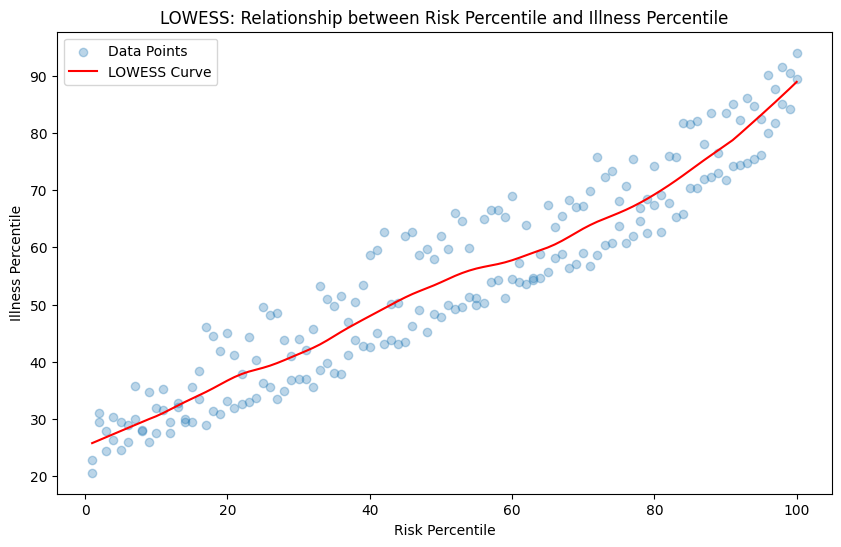

In [25]:
# fit a LOWESS model and conduct some analysis for the result
lowess_results = lowess(illnesses["illness_percentile"], illnesses["risk_percentile"], frac=0.2)
lowess_x, lowess_y = zip(*lowess_results)

plt.figure(figsize=(10, 6))
plt.scatter(illnesses["risk_percentile"], illnesses["illness_percentile"], alpha=0.3, label="Data Points")
plt.plot(lowess_x, lowess_y, color='red', label="LOWESS Curve")
plt.xlabel("Risk Percentile")
plt.ylabel("Illness Percentile")
plt.title("LOWESS: Relationship between Risk Percentile and Illness Percentile")
plt.legend()
plt.show()

## Conclusions and takeaways

Even systems that appear balanced across racial groups at first glance may belie underlying biases in the datasets. Thus, seemingly unbiased predictors can in fact be highly correlated with a biasing variable such as race, gender, income or other relational characteristics.

In this example, bias emerged from using an indicator of need (cost) that was itself influenced by race. Biased estimation of need between races resulted.

To better understand the ways in which race influences health care cost, here is a segment from Obermeyer et al’s paper:

>The literature broadly suggests two main potential channels. **First, poor patients face substantial barriers to accessing health care, even when enrolled in insurance plans.** Although the population we study is entirely insured, there are many other mechanisms by which poverty can lead to disparities in use of health care: geography and differential access to transportation, competing demands from jobs or child care, or knowledge of reasons to seek care (1-3). To the extent that race and socioeconomic status are correlated, these factors will differentially affect Black patients. **Second, race could affect costs directly via several channels: direct (“taste-based”) discrimination, changes to the doctor–patient relationship, or others. A recent trial randomly assigned Black patients to a Black or White primary care provider and found significantly higher uptake of recommended preventive care when the provider was Black (4).** This is perhaps the most rigorous demonstration of this effect, and it fits with a larger literature on potential mechanisms by which race can affect health care directly. For example, it has long been documented that Black patients have reduced trust in the health care system (5), a fact that some studies trace to the revelations of the Tuskegee study and other adverse experiences (6). A substantial literature in psychology has documented physicians’ differential perceptions of Black patients, in terms of intelligence, affiliation (7), or pain tolerance (8). **Thus, whether it is communication, trust, or bias, something about the interactions of Black patients with the health care system itself leads to reduced use of health care. The collective effect of these many channels is to lower health spending substantially for Black patients, conditional on need—a finding that has been appreciated for at least two decades (9).**

In [26]:
data

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t,risk_percentile,illness_percentile
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,...,0,0,0,0,0,0,0,0,36,1
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,...,0,0,1,0,0,1,4,3,86,82
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,4,1
3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,11,1
4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,white,...,0,0,0,0,0,0,1,1,98,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48779,0.611517,0,800.0,0.0,NaN,NaN,NaN,1.090000,148.0,white,...,0,0,0,0,0,0,0,0,8,46
48780,2.615933,0,2200.0,0.0,112.0,NaN,41.4,0.810000,172.0,white,...,0,0,1,0,0,1,1,1,47,69
48781,1.358926,0,800.0,0.0,105.0,NaN,NaN,NaN,NaN,white,...,0,0,1,0,0,1,1,0,24,46
48782,10.990318,0,1300.0,0.0,132.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,3,3,94,89


## Reflection Questions

Here are two final open-ended questions for you to answer.

1. How could we use the data we have to create new proxies for health needs that may be less biased than medical costs?

Some new proxies for health needs might include the number of chronic illnesses each patient has, the number of times a patient has visited the doctor in the past year, or the number of medications a patient is taking. These proxies could be used to create a more accurate risk score that is less biased against Black patients.


2. What are other applications of prediction algorithms where this type of bias may also arise?

In predictive algorithms like Mortgage lending and hiring, bias can arise in data collection, processing, and model training. In the case of mortgage lending, for example, the data used to train the model may be biased against certain groups based on ethnicity and race.


## References

1. K. Fiscella, P. Franks, M. R. Gold, C. M. Clancy, JAMA 283, 2579–2584 (2000).
2. N. E. Adler, K. Newman, Health Aff. 21, 60–76 (2002).
3. N. E. Adler, W. T. Boyce, M. A. Chesney, S. Folkman, S. L. Syme, JAMA 269, 3140–3145 (1993).
4. M. Alsan, O. Garrick, G. C. Graziani, “Does diversity matter for health? Experimental evidence from Oakland” (National Bureau of Economic Research, 2018).
5. K. Armstrong, K. L. Ravenell, S. McMurphy, M. Putt, Am. J. Public Health 97, 1283–1289 (2007).
6. M. Alsan, M. Wanamaker, Q. J. Econ. 133, 407–455 (2018).
7. M. van Ryn, J. Burke, Soc. Sci. Med. 50, 813–828 (2000).
8. K. M. Hoffman, S. Trawalter, J. R. Axt, M. N. Oliver, Proc. Natl. Acad. Sci. U.S.A. 113, 4296–4301 (2016).
9. J. J. Escarce, F. W. Puffer, in Racial and Ethnic Differences in the Health of Older Americans (National Academies Press, 1997), chap. 6; www.ncbi.nlm.nih.gov/books/ NBK109841/.

# Feedback

**Instructors**: Please [provide feedback](https://docs.google.com/forms/d/1UuUVBBMTU_2aMvzsGnTR_4i1w3F6tLaaqdIr7dQrgSI/edit?ts=5efa771b&dods) to help improve this lab.

**Students**: Please [provide feedback](https://docs.google.com/forms/d/1jI8oXRkqD1l1ARuZR1y9W_qkOystPr-YEyywNDez46M/edit?ts=5efa772a&dods) to help improve this lab.
